In [150]:
import numpy as np 
import cupy as cp 
from tqdm import tqdm
from scipy.optimize import minimize
import matplotlib.pyplot as plt 

# Simulation Functions 

In [9]:
def rf(om, alpha, phi):
    halpha = 0.5*alpha
    T = cp.zeros((3,3), dtype=cp.complex64)
    T[0,0] = np.cos(halpha)*np.cos(halpha)
    T[0,1] = np.sin(halpha)*np.sin(halpha)*np.cos(2.0*phi) + 1j*np.sin(halpha)*np.sin(halpha)*np.sin(2*phi)
    T[0,2] = np.sin(alpha)*np.sin(phi) - 1j*np.sin(alpha)*np.cos(phi)
    T[1,0] = np.sin(halpha)*np.sin(halpha)*np.cos(2.0*phi) - 1j*np.sin(halpha)*np.sin(halpha)*np.sin(2.0*phi)
    T[1,1] = np.cos(halpha)*np.cos(halpha)
    T[1,2] = np.sin(alpha)*np.sin(phi) + 1j*np.sin(alpha)*np.cos(phi)
    T[2,0] = -0.5*np.sin(alpha)*np.sin(phi) - 1j*0.5*np.sin(alpha)*np.cos(phi)
    T[2,1] = -0.5*np.sin(alpha)*np.sin(phi) + 1j*0.5*np.sin(alpha)*np.cos(phi)
    T[2,2] = np.cos(alpha)
    return T@om 

def relax(om, T1, T2, dt):
    E1 = np.exp(-dt/T1) 
    E2 = np.exp(-dt/T2)
    om[0,:] = om[0,:] * E2 
    om[1,:] = om[1,:] * E2 
    om[2,:] = om[2,:] * E1 
    om[2,0] = om[2,0] + 1.0 - E1 
    return om 

def spoil(om):
    om[0,:] = cp.roll(om[0,:],  1)
    om[1,:] = cp.roll(om[1,:], -1)
    om[1,-1] = 0.0
    om[0,0] = cp.conj(om[1,0])
    return om 

def sample(om, phi): 
    return om[0,0] * np.exp(-1j*phi) 

def equilibriumMagnetization(nstates):
    om = cp.zeros((3,nstates), dtype=cp.complex64) 
    om[2,0] = 1.0 
    return om 

def spgr(alpha, T1, TR):
    E1 = np.exp(-TR/T1) 
    return np.sin(alpha) * (1 - E1) / (1 - np.cos(alpha)*E1)

# Establishing a Gradient Echo Steady State 

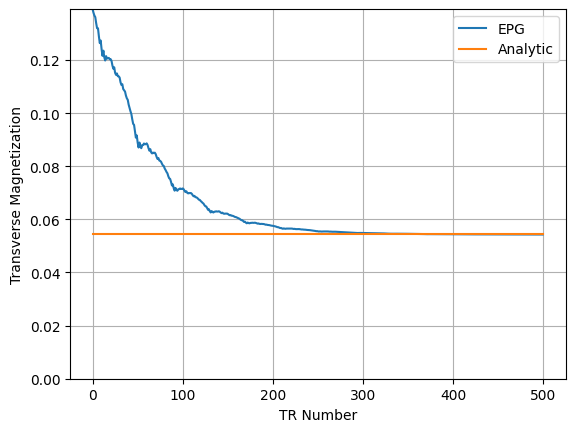

In [15]:

# number of RF pulses to establish a steady state 
nss = 500

# relaxation times [s]
T1 = 0.8
T2 = 0.08 

# flip angle [rad]
alpha = 8.0 * np.pi / 180

# RF spoiling phase increment [rad]
rfspoilinc = 117.0 * np.pi / 180

# repetition time 
TR = 0.005

# allocate the magnetization 
om = equilibriumMagnetization(nss+1)

# loop over RF pulses 
signal = np.zeros((nss,), dtype=np.complex64)
for n in range(nss):

    # update spoiling phase and apply RF pulse
    phi = 0.5*rfspoilinc*(n**2 + n + 2)
    om = rf(om, alpha, phi)

    # sample the transverse magnetization 
    signal[n] = sample(om, phi) 

    # apply relaxation occuring during TR 
    om = relax(om, T1, T2, TR)

    # gradient spoiling 
    om = spoil(om)
    
analytic = spgr(alpha, T1, TR)

plt.figure() 
plt.plot(np.abs(signal))
plt.plot([0,nss],[analytic,analytic])
plt.ylim(0.0, np.max(np.abs(signal)))
plt.ylabel('Transverse Magnetization')
plt.xlabel('TR Number')
plt.grid()
plt.legend(['EPG', 'Analytic'])
plt.show()


# Multi-Flip Angle SPGR

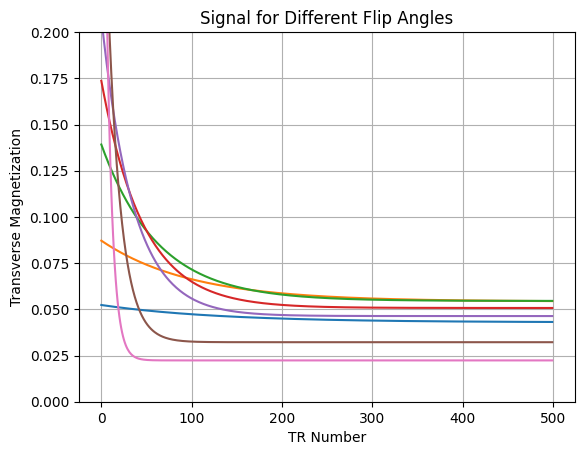

In [97]:

def spgr_epg(T1, T2, TR, alpha, nss=500, rfspoilinc=117.0*np.pi/180):
    om = equilibriumMagnetization(nss+1)
    signal = np.zeros((nss,), dtype=np.complex64)
    for n in range(nss):
        phi = 0.5*rfspoilinc*(n**2 + n + 2)
        om = rf(om, alpha, phi)
        signal[n] = sample(om, phi)
        om = relax(om, T1, T2, TR)
        om = spoil(om)
    return signal 

T1 = 0.8
T2 = 1e-6 
TR = 0.005 
alpha = np.array([3.0, 5.0, 8.0, 10.0, 12.0, 20.0, 30.0], dtype=np.float32) * np.pi / 180 
nss = 500 

signal = np.zeros((nss, alpha.size), dtype=np.complex64)
for n in range(alpha.size):
    signal[:,n] = spgr_epg(T1, T2, TR, alpha[n], nss=nss)

plt.figure() 
plt.plot(np.abs(signal))
plt.ylim(0.0, np.max(np.abs(signal)))
plt.ylabel('Transverse Magnetization')
plt.xlabel('TR Number')
plt.title('Signal for Different Flip Angles')
plt.ylim(0.0, 0.2)
plt.grid()
plt.show()


# Estimate $T_1$ From Multi-Flip Angle SPGR

The ideal signal for a spoiled gradient echo pulse sequence is given by 
$S = \frac{M_0(1 - E_1)\sin(\alpha)}{1 - E_1\cos(\alpha)}$,
where $E_1 = e^{-TR/T_1}$.

After rearranging, the data can be expressed in a linear form as follows:
$\frac{S}{\sin(\alpha)} = E_1\frac{S}{\tan(\alpha)} + M_0(1 - E_1)$

True T1: 0.800000
Estimated T1: 0.802581


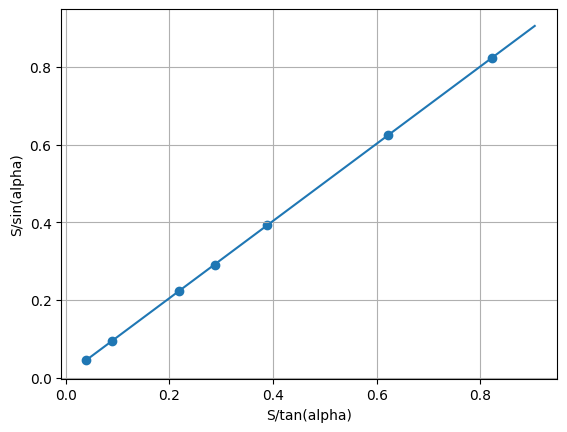

In [107]:

# get magnitude of the signal for all flip angles at end of the RF pulse train 
noise = np.random.randn(alpha.size) + 1j*np.random.randn(alpha.size)
data = np.abs(signal[-1,:] + 1e-4*noise)

# re-arrange data into the linear form 
X = data / np.tan(alpha) 
Y = data / np.sin(alpha) 

# fit a line to the data 
A = np.stack([X, np.ones_like(X)], axis=-1)
beta = np.linalg.inv(A.T@A)@(A.T@Y)
slope = beta[0]
intercept = beta[1]
xplot = np.linspace(np.min(X)*0.9, np.max(X)*1.1, 100)
yplot = xplot * slope + intercept

# T1 is related to the slope of the line 
T1_hat = -TR / np.log(slope) 
print('True T1: %f'%(T1)) 
print('Estimated T1: %f'%(T1_hat)) 

plt.figure()
plt.scatter(X,Y)
plt.plot(xplot, yplot)
plt.xlabel('S/tan(alpha)')
plt.ylabel('S/sin(alpha)')
plt.grid()
plt.show()


# How Can Gradient Echo Based $T_1$ Mapping Be Improved? 

The answer is to use inversion preparation. In the following example, an inversion pulse is applied to the magnetization prior to the start of a steady state spoiled gradient echo sequence.

True T1: 1.400000
Estimated T1: 1.398963


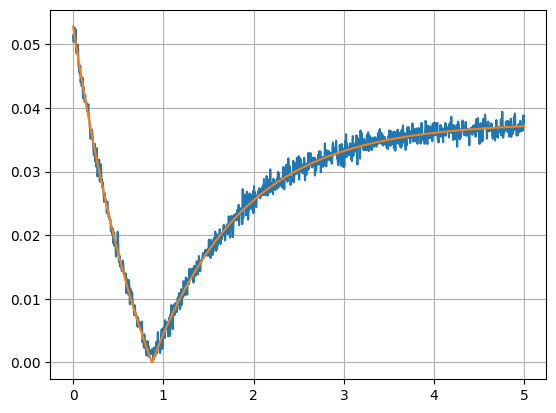

In [131]:

# function to simulate an inversion pulse followed by a train of RF spoiled gradient echoes 
def ir_spgr_epg(T1, T2, TR, alpha, nss=500, rfspoilinc=117.0*np.pi/180):
    om = equilibriumMagnetization(nss+1)
    om[2,0] = -1 # perfect inversion pulse 
    signal = np.zeros((nss,), dtype=np.complex64)
    for n in range(nss):
        phi = 0.5*rfspoilinc*(n**2 + n + 2)
        om = rf(om, alpha, phi)
        signal[n] = sample(om, phi)
        om = relax(om, T1, T2, TR)
        om = spoil(om)
    return signal 


# set up simulation parameters 
T1 = 1.4
T2 = 0.1
TR = 0.005 
alpha = 3.0 * np.pi / 180
nss = 1000 

# get noisy IR-SPGR signal 
ir_signal = ir_spgr_epg(T1, T2, TR, alpha, nss=nss) 
noise = 0.001 * (np.random.randn(ir_signal.size) + 1j*np.random.randn(ir_signal.size))
ir_signal = np.abs(ir_signal + noise) 

# fit T1 to the noisy curve
t = np.arange(0,nss,dtype=np.float32) * TR
model = lambda x: np.abs(x[0] - x[1]*np.exp(-t/x[2]))
cost = lambda x: np.sum((model(x) - ir_signal)**2)
x0 = np.array([ir_signal[-1], 2.0*ir_signal[-1], 1.0])
xopt = minimize(cost, x0).x
A = xopt[0]
B = xopt[1]
T1app = xopt[2]
T1_hat = T1app*(B/A - 1.0)

print('True T1: %f'%(T1)) 
print('Estimated T1: %f'%(T1_hat)) 

fit = model(xopt) 
plt.figure() 
plt.plot(t, np.abs(ir_signal))
plt.plot(t, fit)
plt.grid()
plt.show()


# IR-SPGR Downsides: 

1. Scan times add up: only a handful of k-space lines can be acquired per inversion pulse.
2. Poor SNR: Small flip angles must be used for the true IR signal equation to hold true. 


# MR-Fingerprinting: Introducing Flexibility in the Pulse Sequence 


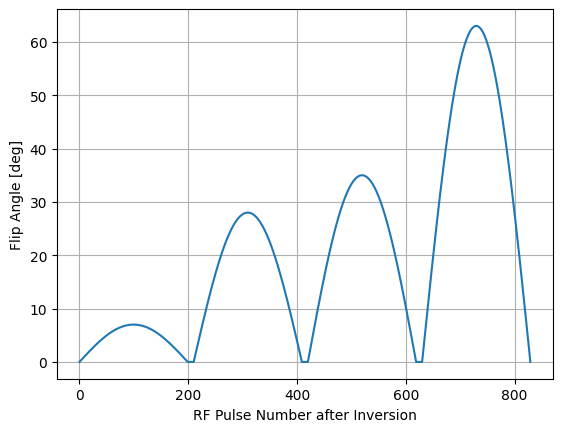

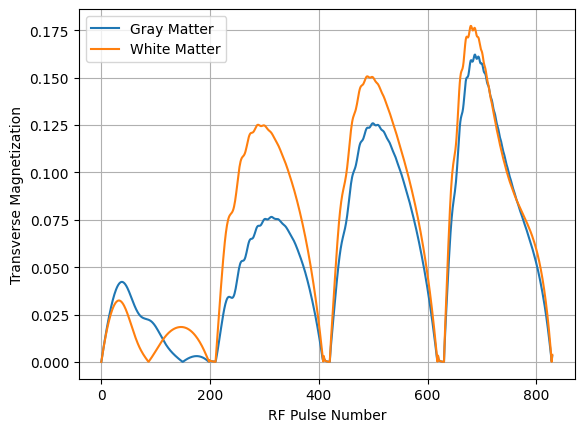

In [149]:
def ir_mrf(T1, T2, TR, alpha):
    om = equilibriumMagnetization(alpha.size+1)
    om[2,0] = -1 
    signal = np.zeros((alpha.size,), dtype=np.complex64)
    for n in range(alpha.size):
        om = rf(om, alpha[n], 0.0)
        signal[n] = sample(om, 0.0)
        om = relax(om, T1, T2, TR)
        om = spoil(om)
    return signal 


base = np.sin(np.linspace(0,np.pi,200))
z = np.zeros((10,), dtype=np.float32)
alpha = 70*np.pi/180 * np.concatenate([0.1*base, z, 0.4*base, z, 0.5*base, z, 0.9*base])
TR = 0.005 

plt.figure()
plt.plot(alpha*180/np.pi)
plt.xlabel('RF Pulse Number after Inversion')
plt.ylabel('Flip Angle [deg]')
plt.grid()
plt.show()

T1a = 1.2
T2a = 0.1
signal_a = ir_mrf(T1a, T2a, TR, alpha)

T1b = 0.7
T2b = 0.07
signal_b = ir_mrf(T1b, T2b, TR, alpha)

plt.figure()
plt.plot(np.abs(signal_a))
plt.plot(np.abs(signal_b))
plt.grid()
plt.xlabel('RF Pulse Number')
plt.ylabel('Transverse Magnetization')
plt.legend(['Gray Matter', 'White Matter'])
plt.show()



In [162]:

inc = 1.04
T1min = 0.5 
T1max = 2.0
T1vals = [T1min]
while T1vals[-1] < T1max: 
    T1vals.append(T1vals[-1]*inc)
T1vals = np.array(T1vals)
T2min = 0.02
T2max = 0.4
T2vals = [T2min]
while T2vals[-1] < T2max: 
    T2vals.append(T2vals[-1]*inc)
T2vals = np.array(T2vals) 

T1dict = np.zeros((T1vals.size*T2vals.size,), dtype=np.float32)
T2dict = np.zeros((T1vals.size*T2vals.size,), dtype=np.float32)
evol = np.zeros((alpha.size, T1vals.size*T2vals.size), dtype=np.complex64)
for n1 in tqdm(range(T1vals.size)): 
    for n2 in range(T2vals.size):
        n = n1*T2vals.size + n2 
        evol[:,n] = ir_mrf(T1vals[n1], T2vals[n2], TR, alpha)
        T1dict[n] = T1vals[n1]
        T2dict[n] = T2vals[n2]


# T1vals = (2.0 - 0.1)*np.random.rand(N) + 0.1
# T2vals = (0.5 - 0.01)*np.random.rand(N) + 0.01
# evol = np.zeros((alpha.size, N), dtype=np.complex64)
# for n in tqdm(range(N)):
#     evol[:,n] = ir_mrf(T1vals[n], T2vals[n], TR, alpha)
 

100%|██████████| 37/37 [30:08<00:00, 48.89s/it]


1.2323577
0.096020415
0.6842845
0.07016117


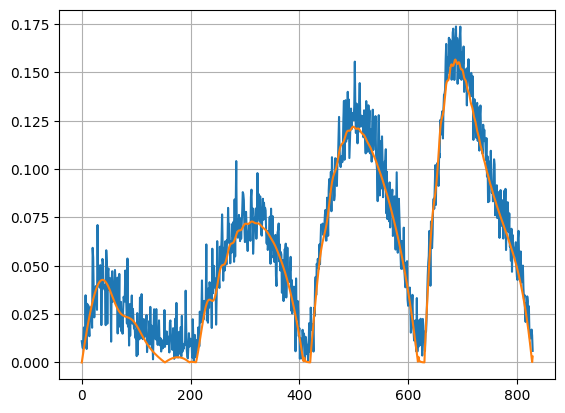

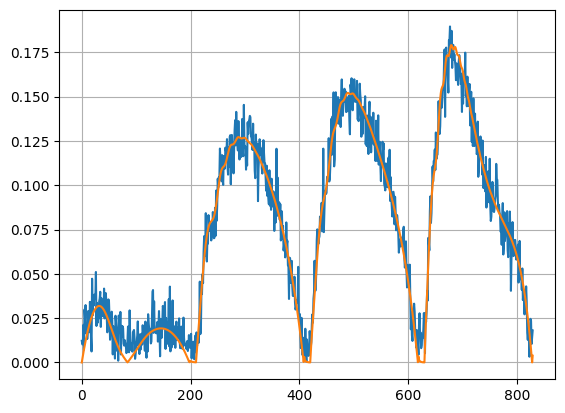

In [174]:
scale = np.linalg.norm(np.abs(evol), axis=0)
evol_scale = np.abs(evol) / scale[None,:]

signal_a_noisy = signal_a + 0.01*(np.random.randn(signal_a.size) + 1j*np.random.randn(signal_a.size))
signal_a_scale = np.abs(signal_a_noisy) / np.linalg.norm(np.abs(signal_a_noisy))
dot_a = np.dot(evol_scale.T, signal_a_scale)
idx_a = np.argmax(dot_a)
print(T1dict[idx_a])
print(T2dict[idx_a])

signal_b_noisy = signal_b + 0.01*(np.random.randn(signal_b.size) + 1j*np.random.randn(signal_b.size))
signal_b_scale = np.abs(signal_b_noisy) / np.linalg.norm(np.abs(signal_b_noisy))
dot_b = np.dot(evol_scale.T, signal_b_scale)
idx_b = np.argmax(dot_b)
print(T1dict[idx_b])
print(T2dict[idx_b])

plt.figure()
plt.plot(np.abs(signal_a_noisy))
plt.plot(np.abs(evol[:,idx_a]))
plt.grid()
plt.show() 

plt.figure()
plt.plot(np.abs(signal_b_noisy))
plt.plot(np.abs(evol[:,idx_b]))
plt.grid()
plt.show() 

# plt.figure()
# plt.plot(dot_a)
# plt.show()

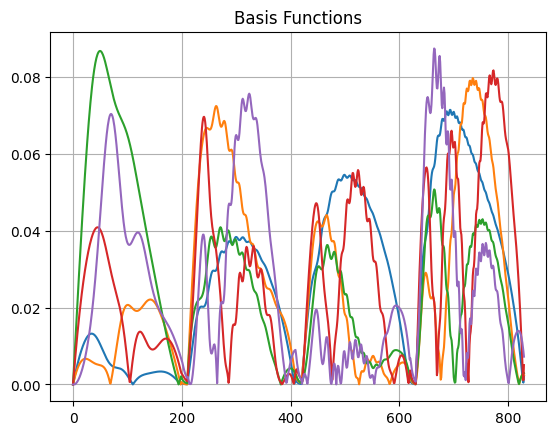

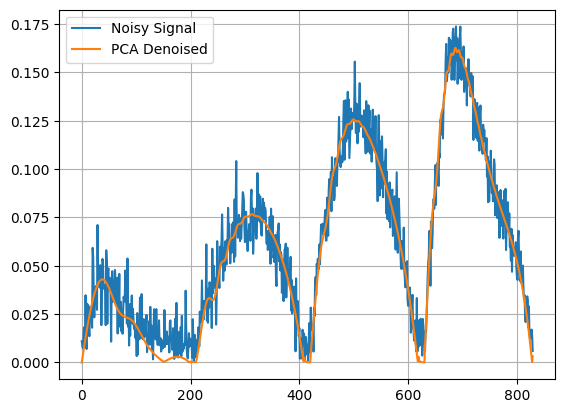

In [182]:
# principal component analysis to find dominant signal evolutions from dictionary
u,s,v = np.linalg.svd(evol,full_matrices=False)
A = u[:,:5]

plt.figure()
plt.plot(np.abs(A))
plt.title('Basis Functions')
plt.grid() 
plt.show()

# find coefficients for each basis function to match noisy data
coef_a = np.linalg.inv(np.conj(A.T)@A)@(np.conj(A.T)@signal_a_noisy)

# project through the subspace to get denoised signal
denoised_a = A@coef_a 

plt.figure()
plt.plot(np.abs(signal_a_noisy))
plt.plot(np.abs(denoised_a))
plt.grid()
plt.legend(['Noisy Signal', 'PCA Denoised'])
plt.show()